# Import modules

In [9]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tqdm import tqdm

%matplotlib inline 

In [10]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from samples.clevr import clevr

# Load pre-trained MRCNN

In [11]:
ROOT_DIR = os.getcwd()

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "temp_images/")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # supresses TF warnings

In [12]:
class InferenceConfig(clevr.ClevrConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.80
    DETECTION_NMS_THRESHOLD = 0.20

config = InferenceConfig()

In [13]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
# CLEVR_MODEL_PATH = '/Users/fl20994/Documents/IAI_CDT/Research_Project/relationalReasoning/INeSyXL/CLEVR-Hans3/ClevrHans_ILP/trained_model/mask_rcnn_clevr_0030_allclasses.h5'
CLEVR_MODEL_PATH = './trained_model/mask_rcnn_clevr_0030_allclasses.h5'

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(CLEVR_MODEL_PATH, by_name=True)

In [14]:
shape_categories = {'cube': 1,
                            'sphere': 2,
                            'cylinder': 3}
material_categories = {'rubber': 1,
                               'metal': 2}
color_categories = {'gray': 1,
                            'blue': 2,
                            'brown': 3,
                            'yellow': 4,
                            'red': 5,
                            'green': 6,
                            'purple': 7,
                            'cyan': 8}
size_categories = {'small': 1,
                           'large': 2}
class_names = ['BG']
for shape in shape_categories:
    for mat in material_categories:
        for col in color_categories:
            for size in size_categories:
                class_name = shape + " " + mat + " " + col + " " + size
                class_names.append(class_name)

# Inference on random img

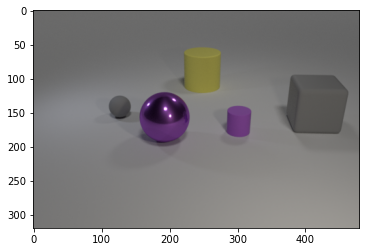

In [15]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names[1]))
image = image[:,:,:3]
plt.imshow(image)

In [ ]:
# Visualize results
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names[1]))
image = image[:,:,:3]
results = model.detect([image], verbose=0)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

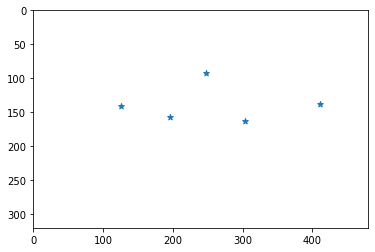

In [22]:
# find centre of each object
r['rois'], [class_names[i] for i in r['class_ids']], r['rois'][0]


# centroids = [[int((roi[1] + roi[3])/2), int((roi[0] + roi[2])/2)] for roi in rois]

rois = r['rois'].tolist()
centroids_x = [(roi[1] + roi[3])/2 for roi in rois]
centroids_y = [(roi[0] + roi[2])/2 for roi in rois]
plt.scatter(centroids_x,centroids_y, marker = '*')
plt.xlim(0,image.shape[1])
plt.ylim(image.shape[0], 0)
plt.show()



In [82]:
partner_idx = 0
reference_idx = 0
relation = 'right_of'
class_names[r['class_ids'][partner_idx]]

# print(f'{relation}({class_names[r['class_ids'][partner_idx]]})')
print(f'{relation}({class_names[0]})')
print(class_names[r['class_ids'][0]])
#({class_names[r['class_ids'][partner_idx]]})')

# full_oblist.index(class_names[r['class_ids'][0]].split())

right_of(BG)
cube rubber gray large


1

# Write to Aleph Files

In [23]:
ROOT_DIR = os.getcwd()

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "temp_images/")

In [93]:
# Inference on all images in sample images folder
# oblist contains list of objects in each of the images


In [125]:
def open_files():

    output_filename = 'hans_aleph'
    output_directory = os.getcwd()

    os.makedirs(ROOT_DIR, exist_ok=True)

    os.makedirs(output_directory, exist_ok=True)

    b_file = open(output_directory + '/' + output_filename + '.b', 'w')
    f_file = open(output_directory + '/' + output_filename + '.f', 'w')
    n_file = open(output_directory + '/' + output_filename + '.n', 'w')
    bk_file = open(output_directory + '/' + output_filename + '.bk', 'w')

    return b_file, f_file, n_file, bk_file

def write_basic_preds(bk_file, color_categories, material_categories, size_categories, shape_categories):

    attribute_dict = {'color': list(color_categories.keys()), 'material': list(material_categories.keys()),
                        'size': list(size_categories.keys()), 'shape': list(shape_categories.keys())}

    for attribute in list(attribute_dict.keys()):
        bk_file.write(f":- discontiguous has_{attribute}/2.\n")
    bk_file.write(f":- discontiguous contains/2.\n")
    bk_file.write(f":- discontiguous right_of/3.\n")
    bk_file.write(f":- discontiguous left_of/3.\n")

    bk_file.write("\n")

    for category in list(attribute_dict.keys()):
        for attribute in attribute_dict[category]:
            bk_file.write(f"{category}({attribute}).\n")

    bk_file.write("\n")

    return attribute_dict

def write_object_preds(bk_file, attribute_dict):

    class_names[r['class_ids'][0]]

    full_oblist = []
    for shape in attribute_dict['shape']:
        for material in attribute_dict['material']:
            for color in attribute_dict['color']:
                for size in attribute_dict['size']:
                    full_oblist.append([shape, material, color, size])

    object_count = 0 
    for object in full_oblist:
        object_id = f'oid_{object_count}'
        shape, material, color, size = object
        bk_file.write(f"has_shape({object_id}, {shape}).\n")
        bk_file.write(f"has_material({object_id}, {material}).\n")
        bk_file.write(f"has_color({object_id}, {color}).\n")
        bk_file.write(f"has_size({object_id}, {size}).\n")
        bk_file.write(f"\n")
        object_count += 1
    
    return full_oblist

def write_img_facts(bk_file, full_oblist, oblist, centroids):

    example_count = 0
    for img_objects, img_centroids_x, img_centroids_y in zip(oblist, centroids['X'], centroids['Y']):
        bk_file.write("\n")
        example_id = f"example_{example_count}"

        for object in img_objects:
            shape, material, color, size = object.split()

            # find the index id of the object recognised
            object_idx = full_oblist.index([shape, material, color, size])
            object_id = f'oid_{object_idx}'
            bk_file.write(f"contains({object_id}, {example_id}).\n")
        
        rel_preds = get_relation_preds(img_centroids_x, img_centroids_y, full_oblist, example_count, img_objects)
        for pred in rel_preds:
            bk_file.write(pred)
        
        example_count += 1

def close_files(b_file, f_file, n_file, bk_file):
    b_file.close()
    bk_file.close()
    f_file.close()
    n_file.close()

def write_img_object_preds(oblist):
    '''Ignore for now.
    This write predicates for only the object that appear in the training set. NOT for all possible objects'''
    example_count = 0
    object_count = 0
    for img_objects in oblist:
        bk_file.write("\n")
        example_id = f"example_{example_count}"
        example_count += 1

        for object in img_objects:
            object_id = f'oid_{object_count}'
            shape, material, color, size = object.split()
            bk_file.write(f"has_shape({object_id}, {shape}).\n")
            bk_file.write(f"has_material({object_id}, {material}).\n")
            bk_file.write(f"has_color({object_id}, {color}).\n")
            bk_file.write(f"has_size({object_id}, {size}).\n")
            object_count += 1
        
        bk_file.write(f"contains({object_id}, {example_id}).\n")

def inference(IMAGE_DIR, model):

    file_names = sorted(next(os.walk(IMAGE_DIR))[2])

    if '.DS_Store' in file_names:
        file_names.remove(".DS_Store")

    oblist = []
    ilp_classes = []
    centroids = {'X':[], 'Y':[]}

    print('Detecting objects...')


    for filename in tqdm(file_names):
        image = skimage.io.imread(os.path.join(IMAGE_DIR, filename))
        image = image[:,:,:3]
        results = model.detect([image], verbose=0)
        r = results[0]
        oblist.append([class_names[r['class_ids'][i]] for i in range(len(r['class_ids']))])

        # get centroids
        rois = r['rois'].tolist()
        centroids['X'].append([(roi[1] + roi[3])/2 for roi in rois])
        centroids['Y'].append([(roi[0] + roi[2])/2 for roi in rois])

        ilp_classes.append(f'c{filename[19]}')
    
    return oblist, ilp_classes, centroids

def get_relation_preds(centroidsX, centroidsY, full_oblist, eg_num, img_objects):

    rel_preds = []
    for partner_idx in range(len(centroidsX)):
        for reference_idx in range(len(centroidsX)):
            if partner_idx==reference_idx:
                continue
            
            # ref_id = full_oblist.index(class_names[r['class_ids'][reference_idx]].split())
            # part_id = full_oblist.index(class_names[r['class_ids'][partner_idx]].split())

            ref_id = full_oblist.index(img_objects[reference_idx].split())
            part_id = full_oblist.index(img_objects[partner_idx].split())

            if centroidsX[partner_idx] > centroidsX[reference_idx]:
                x_relation = 'right_of'
            elif centroidsX[partner_idx] < centroidsX[reference_idx]:
                x_relation = 'left_of'
            
            if centroidsY[partner_idx] > centroidsY[reference_idx]:
                y_relation = 'in_front'
            elif centroidsY[partner_idx] < centroidsY[reference_idx]:
                y_relation = 'behind'
            
            rel_preds.append(f'{x_relation}(oid_{ref_id}, oid_{part_id}, example_{eg_num}).\n')
            rel_preds.append(f'{y_relation}(oid_{ref_id}, oid_{part_id}, example_{eg_num}).\n')

    return rel_preds

def write_ground_truths(ilp_classes, f_file, n_file):
    for id in range(0,len(ilp_classes)):
        if ilp_classes[id] == 'c0':
            f_file.write(f"true_class(example_{id}).\n")
        else:
            n_file.write(f"true_class(example_{id}).\n")

def write_aleph_settings(b_file, features = ['shape','material','color','size'], \
    id_column = "oid", output_filename = "hans_aleph"):

    # write settings for Aleph
    b_file.write(":- modeh(1, true_class(+example)).\n")
    b_file.write("\n")

    b_file.write(f":- modeb(*, contains(-{id_column}, +example)).\n")

    # modes
    for feature in features:
        b_file.write(f":- modeb(*, has_{feature}(+{id_column}, #{feature})).\n")

    b_file.write(f":- modeb(*, left_of(+{id_column}, +{id_column}, +example)).\n")
    b_file.write(f":- modeb(*, right_of(+{id_column}, +{id_column}, +example)).\n")

    b_file.write("\n")

    # determinations
    b_file.write(":- determination(true_class/1, contains/2).\n")

    for feature in features:
        b_file.write(f":- determination(true_class/1, has_{feature}/2).\n")
    b_file.write(f":- determination(true_class/1, left_of/3).\n")
    b_file.write(f":- determination(true_class/1, right_of/3).\n")

    # write relations


    b_file.write("\n")
    
    b_file.write(":- set(i,4).\n")
    b_file.write(":- set(verbosity,0).\n")
    b_file.write(":- set(minpos,3).\n")
    b_file.write(":- set(noise,10).\n")
    b_file.write(":- set(clauselength, 20).\n")
    b_file.write(f":- consult('{output_filename + '.bk'}').")


In [ ]:
oblist, ilp_classes, centroids = inference(IMAGE_DIR, model)

In [126]:
b_file, f_file, n_file, bk_file = open_files()
write_aleph_settings(b_file)
attribute_dict = write_basic_preds(bk_file, color_categories, material_categories, size_categories, shape_categories)
full_oblist = write_object_preds(bk_file, attribute_dict)

write_img_facts(bk_file, full_oblist, oblist, centroids)
write_ground_truths(ilp_classes, f_file, n_file)
close_files(b_file, f_file, n_file, bk_file)